# 가위바위보 분류기 만들기

---
## 목차
0. 개선사항
1. 데이터 준비하기
2. 모델 만들기
3. trainer 만들기
4. 모델 테스트
5. 모델 성능 개선 - 하이퍼파라미터 튜닝 및 모델 만들기
6. 회고
---

## 0. 개선사항
- 오버피팅 억제를 위해 train 데이터셋 양을 늘림 : 300개에서 3600개로
- 오버피팅 여부의 정확한 확인을 위해
    - accuracy와 val_loss를 함께 고려
    - train_loss와 val_loss의 흐름이 유사한지를 확인
- 일반화 성능 향상을 위해 
    - layer 수, 에폭, 배치 사이즈 늘림
    - learning rate=0.00001로 작게 조정
- validation data의 성능이 정확도 93으로 높은 결과가 나왔으나, test accuracy가 66 이상으로 개선되지 않음
    - 모델의 일반화 성능 향상을 위해 train 데이터셋을 다양한 데이터의 구성으로 변경하여 다시 시도해 볼 예정

## 1. 데이터 준비하기
### 라이브러리 버전 확인

In [31]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.22.2


### 데이터 준비하기
- 데이터 불러오기 + Resize 하기   
    - train, test data 모두 Resize
    - 224x224 를 28x28 사이즈로

In [32]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


In [44]:
# 이미지 사이즈 224x224에서 28x28로 변경하기

def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")
    
    print(len(images), " images resized.")
    
    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        
    print(len(images), " images resized.")
    
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor3"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")


# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 28x28 사이즈로 변경
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock3"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")


# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 28x28 사이즈로 변경
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper3"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/validation/scissor3"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")


# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 28x28 사이즈로 변경
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/validation/rock3"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")


# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 28x28 사이즈로 변경
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/validation/paper3"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

1200  images resized.
1200  images resized.
가위 이미지 resize 완료!
1200  images resized.
1200  images resized.
바위 이미지 resize 완료!
1200  images resized.
1200  images resized.
보 이미지 resize 완료!
167  images resized.
167  images resized.
가위 이미지 resize 완료!
200  images resized.
200  images resized.
바위 이미지 resize 완료!
200  images resized.
200  images resized.
보 이미지 resize 완료!


In [34]:
# 이미지 사이즈 확인

image1 = Image.open( os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper3/0.jpg")
print(image1)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=28x28 at 0x7F136111FB50>


### 가위, 바위, 보 데이터를 읽을 수 있는 load_data() 함수 만들기
- load_data() 함수는 입력으로 이미지가 있는 폴더 위치를 받는다.(rock_scissor_paper 폴더 위치를 적어주기)
- 가위바위보는 3개의 클래스 즉, 가위: 0, 바위: 1, 보: 2 로 라벨링이 될 것

In [45]:
import numpy as np

def load_data(img_path, number_of_data=3600):   # 1200개씩 총 3600장의 이미지 데이터
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    
    import glob
    import os

    s_images = glob.glob(img_path + "/scissor3/*.jpg")
    r_images = glob.glob(img_path + "/rock3/*.jpg")
    p_images = glob.glob(img_path + "/paper3/*.jpg")
    print("Scissors:", len(s_images))
    print("Rocks:", len(r_images))
    print("Papers:", len(p_images))
    
    # 이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    
    idx=0
    for file in glob.iglob(img_path+'/scissor3/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img   # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1
        
    for file in glob.iglob(img_path+'/rock3/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img   # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1
        
    for file in glob.iglob(img_path+'/paper3/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img   # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/validation"
(x_valid, y_valid)=load_data(image_dir_path, number_of_data=567)
x_train_norm = x_train/255.0     # 입력은 0~1 사이의 값으로 정규화
x_valid_norm = x_valid/255.0

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

Scissors: 1200
Rocks: 1200
Papers: 1200
학습데이터(x_train)의 이미지 개수는 3600 입니다.
Scissors: 167
Rocks: 200
Papers: 200
학습데이터(x_train)의 이미지 개수는 567 입니다.
x_train shape: (3600, 28, 28, 3)
y_train shape: (3600,)


### 이미지 불러와서 확인하기
- np.random.randint : 전체 이미지를 리스트로 불러와 그 중 랜덤으로 1개 선택하여 확인
- 현재 가위(0), 바위(1), 보(2) 순서로 나열되어있는 이미지가 잘 라벨링 되어있는지 확인

471
라벨:  0
라벨:  1
라벨:  2


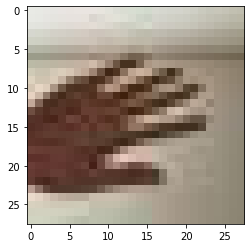

In [37]:
import matplotlib.pyplot as plt

idx=np.random.randint(low=0, high=1200, size=1)[0]
print(idx)

plt.imshow(x_train[0])
print('라벨: ', y_train[0])
plt.imshow(x_train[idx+1200])
print('라벨: ', y_train[idx+1200])
plt.imshow(x_train[idx+2400])
print('라벨: ', y_train[idx+2400])

## 2. 모델 만들기   
오버피팅 억제를 위해 아래 3가지를 활용하였다.  
- 가중치 초기화 : Relu에 특화된 He 초기값 사용. 모든 층에서 활성화값들을 균일하게 분포시킴
- 배치 정규화 : 각 층이 활성화를 적당히 퍼트리도록 강제하는 역할. 아래와 같은 이점이 있다.
    - 학습 속도를 개선
    - 초기값에 크게 의존하지 않음
    - 오버피팅을 억제
- 드롭아웃 : 신경망 모델이 복잡해진 경우 오버피팅을 억제하는 방식  

In [38]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import optimizers

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax', kernel_initializer='he_normal'))
          
print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  10
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (N

## 3. trainer 만들기
- 학습률 0.001에서 0.00001로 조정
- Adam을 활용하여 매개변수 최적화를 시도

In [39]:
learning_rate = 0.00001
adam = optimizers.Adam(learning_rate = learning_rate)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [46]:
history = model.fit(x_train_norm, y_train, batch_size = 64, validation_data=(x_valid_norm, y_valid), epochs = 20, verbose = 1)

Epoch 1/20
57/57 [==============================] - 5s 76ms/step - loss: 0.0357 - accuracy: 0.9922 - val_loss: 5.3136 - val_accuracy: 0.4727
Epoch 2/20
57/57 [==============================] - 4s 75ms/step - loss: 0.0337 - accuracy: 0.9906 - val_loss: 2.6629 - val_accuracy: 0.7672
Epoch 3/20
57/57 [==============================] - 4s 75ms/step - loss: 0.0204 - accuracy: 0.9950 - val_loss: 1.6349 - val_accuracy: 0.8871
Epoch 4/20
57/57 [==============================] - 4s 74ms/step - loss: 0.0177 - accuracy: 0.9944 - val_loss: 2.6543 - val_accuracy: 0.8624
Epoch 5/20
57/57 [==============================] - 4s 74ms/step - loss: 0.0226 - accuracy: 0.9950 - val_loss: 2.7253 - val_accuracy: 0.7901
Epoch 6/20
57/57 [==============================] - 4s 73ms/step - loss: 0.0187 - accuracy: 0.9956 - val_loss: 4.5948 - val_accuracy: 0.8219
Epoch 7/20
57/57 [==============================] - 5s 82ms/step - loss: 0.0141 - accuracy: 0.9967 - val_loss: 3.7233 - val_accuracy: 0.8695
Epoch 8/20
57

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f13852c4ca0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 545, in __del__
    gen_dataset_ops.delete_iterator(
  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1263, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


- train, validation data의 정확도 시각화

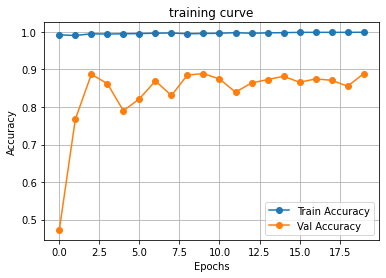

In [47]:
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('training curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 4. 모델 테스트
- test data 만들기

테스트 데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)
라벨:  0


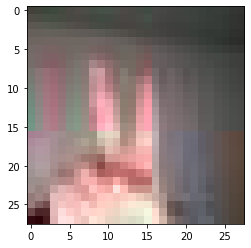

In [48]:
# x_test, y_test 만들기

import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("테스트 데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

# 이미지 불러오기
import matplotlib.pyplot as plt

plt.imshow(x_test[0])
print('라벨: ', y_test[0])

- test 정확도 측정하기

In [49]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

10/10 - 0s - loss: 18.3230 - accuracy: 0.2300
test_loss: 18.32297134399414
test_accuracy: 0.23000000417232513
model.predict() 결과 :  [4.7770163e-01 5.2229828e-01 4.3926662e-13]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  0


## 5. 모델 성능 개선
### 정확도 0.23 : 정확도 올리기 위해 배치 사이즈 64->128, 에폭 20->50으로 조정

In [50]:
history = model.fit(x_train_norm, y_train, batch_size = 128, validation_data=(x_valid_norm, y_valid), epochs = 50, verbose = 1)

Epoch 1/50
29/29 [==============================] - 4s 141ms/step - loss: 0.0079 - accuracy: 0.9981 - val_loss: 3.0718 - val_accuracy: 0.8765
Epoch 2/50
29/29 [==============================] - 4s 139ms/step - loss: 0.0093 - accuracy: 0.9978 - val_loss: 2.8878 - val_accuracy: 0.8836
Epoch 3/50
29/29 [==============================] - 4s 137ms/step - loss: 0.0071 - accuracy: 0.9986 - val_loss: 2.3310 - val_accuracy: 0.8924
Epoch 4/50
29/29 [==============================] - 4s 139ms/step - loss: 0.0055 - accuracy: 0.9997 - val_loss: 2.2729 - val_accuracy: 0.8907
Epoch 5/50
29/29 [==============================] - 4s 139ms/step - loss: 0.0074 - accuracy: 0.9983 - val_loss: 2.5070 - val_accuracy: 0.8801
Epoch 6/50
29/29 [==============================] - 4s 141ms/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 2.4965 - val_accuracy: 0.8871
Epoch 7/50
29/29 [==============================] - 4s 139ms/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 2.8296 - val_accuracy: 0.8783
Epoch 

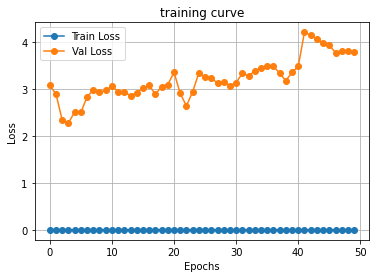

In [51]:
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('training curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 시각화 결과
- loss가 상승하며 종료되어 오버피팅 발생.   
- 모델의 layer를 한 층 추가하여(더 깊게 쌓아) 성능 향상 시도

In [52]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import optimizers

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax', kernel_initializer='he_normal'))
          
print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  13
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            

In [53]:
learning_rate = 0.00001
adam = optimizers.Adam(learning_rate = learning_rate)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [54]:
history = model.fit(x_train_norm, y_train, batch_size = 64, validation_data=(x_valid_norm, y_valid), epochs = 20, verbose = 1)

Epoch 1/20
57/57 [==============================] - 6s 93ms/step - loss: 0.5598 - accuracy: 0.7894 - val_loss: 1.0052 - val_accuracy: 0.4921
Epoch 2/20
57/57 [==============================] - 5s 91ms/step - loss: 0.1502 - accuracy: 0.9481 - val_loss: 0.6943 - val_accuracy: 0.7319
Epoch 3/20
57/57 [==============================] - 5s 90ms/step - loss: 0.0854 - accuracy: 0.9728 - val_loss: 0.7692 - val_accuracy: 0.6596
Epoch 4/20
57/57 [==============================] - 5s 91ms/step - loss: 0.0627 - accuracy: 0.9825 - val_loss: 0.9205 - val_accuracy: 0.6720
Epoch 5/20
57/57 [==============================] - 5s 90ms/step - loss: 0.0427 - accuracy: 0.9856 - val_loss: 0.5128 - val_accuracy: 0.8060
Epoch 6/20
57/57 [==============================] - 5s 91ms/step - loss: 0.0385 - accuracy: 0.9889 - val_loss: 0.4348 - val_accuracy: 0.8413
Epoch 7/20
57/57 [==============================] - 5s 90ms/step - loss: 0.0304 - accuracy: 0.9892 - val_loss: 0.3126 - val_accuracy: 0.8959
Epoch 8/20
57

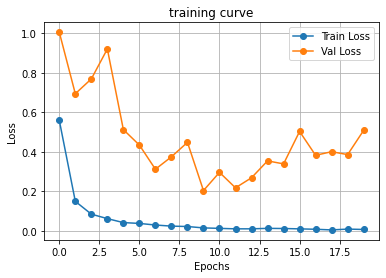

In [55]:
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('training curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

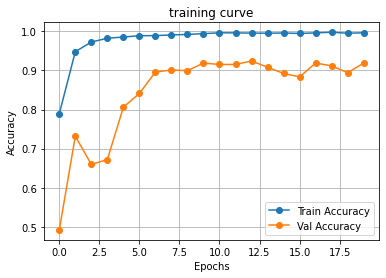

In [56]:
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('training curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

10/10 - 0s - loss: 14.7215 - accuracy: 0.3333
test_loss: 14.721549034118652
test_accuracy: 0.3333333432674408
model.predict() 결과 :  [9.9999988e-01 9.9540635e-08 4.5860468e-10]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


### 시각화 및 정확도 결과
- 시각화하여 그래프를 본 결과 이전 모델보다는 제대로 학습을 하는 것으로 보임
- test accuracy도 23에서 33으로 상승
- 층을 2개 더 쌓아 모델 성능 개선 시도 (총 5개의 층)

In [59]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import optimizers

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=96, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax', kernel_initializer='he_normal'))
          
print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  17
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
batch_normalization_11 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling 

In [60]:
learning_rate = 0.00001
adam = optimizers.Adam(learning_rate = learning_rate)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [61]:
history = model.fit(x_train_norm, y_train, batch_size = 64, validation_data=(x_valid_norm, y_valid), epochs = 20, verbose = 1)

Epoch 1/20
57/57 [==============================] - 34s 589ms/step - loss: 0.3570 - accuracy: 0.8594 - val_loss: 0.9245 - val_accuracy: 0.5520
Epoch 2/20
57/57 [==============================] - 33s 585ms/step - loss: 0.1124 - accuracy: 0.9631 - val_loss: 2.1658 - val_accuracy: 0.3527
Epoch 3/20
57/57 [==============================] - 33s 579ms/step - loss: 0.0674 - accuracy: 0.9753 - val_loss: 2.4017 - val_accuracy: 0.4427
Epoch 4/20
57/57 [==============================] - 33s 582ms/step - loss: 0.0461 - accuracy: 0.9861 - val_loss: 1.9588 - val_accuracy: 0.5185
Epoch 5/20
57/57 [==============================] - 33s 579ms/step - loss: 0.0286 - accuracy: 0.9900 - val_loss: 1.3873 - val_accuracy: 0.6720
Epoch 6/20
57/57 [==============================] - 33s 581ms/step - loss: 0.0241 - accuracy: 0.9881 - val_loss: 0.8726 - val_accuracy: 0.8236
Epoch 7/20
57/57 [==============================] - 33s 581ms/step - loss: 0.0217 - accuracy: 0.9914 - val_loss: 0.5334 - val_accuracy: 0.8307

### 새로 배운 점
- loss와 val_loss의 트렌드(흐름)이 같아지면 학습을 잘하고 있다고 판단(일반화 성능이 좋다.)할 수 있음을 새로 알게 됨.
- epoch 11 정도면 충분했던 상황으로 차후 early stopping에 대해 더 알아보기로 (오버피팅 나기 전에 일찍 실험을 종료시키기)

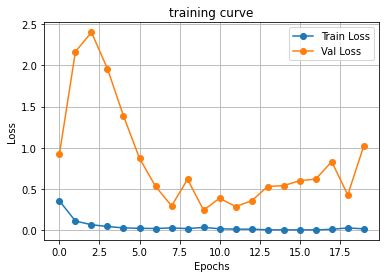

In [62]:
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('training curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

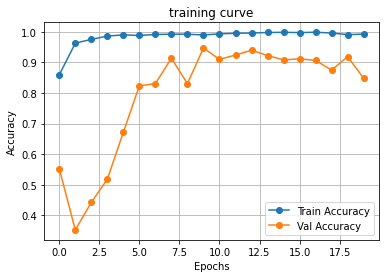

In [63]:
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('training curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

10/10 - 1s - loss: 3.9873 - accuracy: 0.6667
test_loss: 3.987347364425659
test_accuracy: 0.6666666865348816
model.predict() 결과 :  [9.9557942e-01 4.4205519e-03 3.0699105e-09]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


## test data 정확도 66 달성
- test_accuracy: 0.66  
더 높은 모델 성능을 위해 
    - Conv2D layer 1층 추가
    - MaxPool2D 연달아 나오지 않도록 배치

In [65]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import optimizers

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=96, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax', kernel_initializer='he_normal'))
          
print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  19
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling 

In [66]:
learning_rate = 0.00001
adam = optimizers.Adam(learning_rate = learning_rate)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### layer를 한 층 더 쌓은 만큼 에폭도 20에서 30으로 조정

In [67]:
history = model.fit(x_train_norm, y_train, batch_size = 64, validation_data=(x_valid_norm, y_valid), epochs = 30, verbose = 1)

Epoch 1/30
57/57 [==============================] - 35s 600ms/step - loss: 0.4088 - accuracy: 0.8492 - val_loss: 1.0656 - val_accuracy: 0.3351
Epoch 2/30
57/57 [==============================] - 34s 595ms/step - loss: 0.0929 - accuracy: 0.9689 - val_loss: 1.2139 - val_accuracy: 0.4480
Epoch 3/30
57/57 [==============================] - 34s 599ms/step - loss: 0.0468 - accuracy: 0.9861 - val_loss: 1.0314 - val_accuracy: 0.5785
Epoch 4/30
57/57 [==============================] - 34s 596ms/step - loss: 0.0409 - accuracy: 0.9853 - val_loss: 1.2990 - val_accuracy: 0.5750
Epoch 5/30
57/57 [==============================] - 34s 597ms/step - loss: 0.0727 - accuracy: 0.9767 - val_loss: 0.7883 - val_accuracy: 0.7284
Epoch 6/30
57/57 [==============================] - 34s 589ms/step - loss: 0.0245 - accuracy: 0.9936 - val_loss: 0.4584 - val_accuracy: 0.8519
Epoch 7/30
57/57 [==============================] - 34s 595ms/step - loss: 0.0135 - accuracy: 0.9950 - val_loss: 0.3978 - val_accuracy: 0.9012

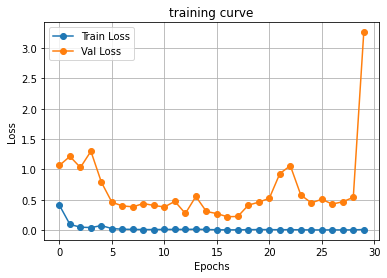

In [69]:
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('training curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

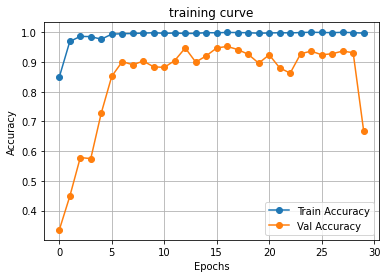

In [70]:
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('training curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

10/10 - 1s - loss: 3.3131 - accuracy: 0.6367
test_loss: 3.313122510910034
test_accuracy: 0.6366666555404663
model.predict() 결과 :  [9.9999905e-01 2.2908949e-07 6.7289182e-07]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


### 시각화 및 정확도 결과
- loss, accuracy가 마지막에 튀면서 test accuracy가 66에서 63으로 소폭 감소
- layer 추가하여 총 7개 층으로 다시 모델링

In [72]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import optimizers

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=96, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(input_shape=(28,28,3), filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax', kernel_initializer='he_normal'))
          
print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  21
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
batch_normalization_22 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_23 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling 

In [73]:
learning_rate = 0.00001
adam = optimizers.Adam(learning_rate = learning_rate)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### 모델 층을 키운 만큼 배치 사이즈 64 -> 128, 에폭 30 -> 40으로 조정

In [75]:
history = model.fit(x_train_norm, y_train, batch_size = 128, validation_data=(x_valid_norm, y_valid), epochs = 40, workers=4, verbose = 1)

Epoch 1/40
29/29 [==============================] - 40s 1s/step - loss: 0.0765 - accuracy: 0.9736 - val_loss: 2.0647 - val_accuracy: 0.3527
Epoch 2/40
29/29 [==============================] - 40s 1s/step - loss: 0.0557 - accuracy: 0.9822 - val_loss: 2.2169 - val_accuracy: 0.3527
Epoch 3/40
29/29 [==============================] - 40s 1s/step - loss: 0.0346 - accuracy: 0.9900 - val_loss: 3.3442 - val_accuracy: 0.3527
Epoch 4/40
29/29 [==============================] - 41s 1s/step - loss: 0.0188 - accuracy: 0.9947 - val_loss: 4.3048 - val_accuracy: 0.3527
Epoch 5/40
29/29 [==============================] - 40s 1s/step - loss: 0.0126 - accuracy: 0.9961 - val_loss: 5.1030 - val_accuracy: 0.3527
Epoch 6/40
29/29 [==============================] - 41s 1s/step - loss: 0.0168 - accuracy: 0.9947 - val_loss: 6.6406 - val_accuracy: 0.3527
Epoch 7/40
29/29 [==============================] - 41s 1s/step - loss: 0.0122 - accuracy: 0.9947 - val_loss: 6.3540 - val_accuracy: 0.3545
Epoch 8/40
29/29 [==

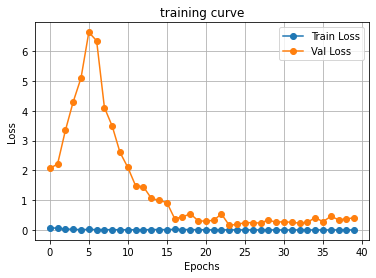

In [76]:
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('training curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

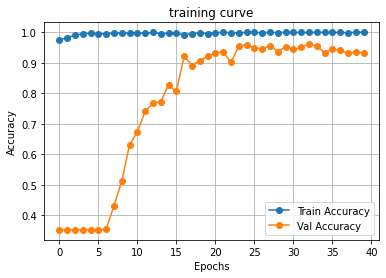

In [77]:
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('training curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [81]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

10/10 - 1s - loss: 12.1589 - accuracy: 0.3333
test_loss: 12.158921241760254
test_accuracy: 0.3333333432674408
model.predict() 결과 :  [8.587555e-08 9.999999e-01 1.588253e-08]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  0


In [80]:
test_loss, test_accuracy = model.evaluate(x_valid_norm,y_valid, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

18/18 - 1s - loss: 0.4125 - accuracy: 0.9330
test_loss: 0.41246622800827026
test_accuracy: 0.9329805970191956
model.predict() 결과 :  [8.587555e-08 9.999999e-01 1.588253e-08]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  0


### 시각화 및 정확도 결과
- test accuracy는 33으로 하락
- validation accuracy는 93으로 높은 수준을 보여줌  
- 사용한 test data를 확인해보니 모든 사진이 거의 똑같은 형태라 test data를 교체해보기로 함.

### test data 교체

In [82]:
# 이미지 사이즈 224x224에서 28x28로 변경하기

def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")
    
    print(len(images), " images resized.")
    
    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        
    print(len(images), " images resized.")
    
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor3"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")


# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 28x28 사이즈로 변경
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock3"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")


# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 28x28 사이즈로 변경
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper3"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/validation/scissor3"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")


# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 28x28 사이즈로 변경
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/validation/rock3"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")


# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 28x28 사이즈로 변경
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/validation/paper3"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")


# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 28x28 사이즈로 변경
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")


# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 28x28 사이즈로 변경
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

1200  images resized.
1200  images resized.
가위 이미지 resize 완료!
1200  images resized.
1200  images resized.
바위 이미지 resize 완료!
1200  images resized.
1200  images resized.
보 이미지 resize 완료!
167  images resized.
167  images resized.
가위 이미지 resize 완료!
200  images resized.
200  images resized.
바위 이미지 resize 완료!
200  images resized.
200  images resized.
보 이미지 resize 완료!
100  images resized.
100  images resized.
가위 이미지 resize 완료!
100  images resized.
100  images resized.
바위 이미지 resize 완료!
100  images resized.
100  images resized.
보 이미지 resize 완료!


테스트 데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)
라벨:  0


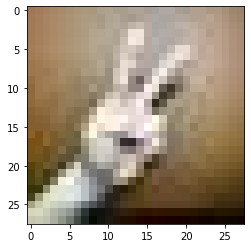

In [83]:
# x_test, y_test 만들기

import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("테스트 데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

# 이미지 불러오기
import matplotlib.pyplot as plt

plt.imshow(x_test[0])
print('라벨: ', y_test[0])

In [84]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

10/10 - 1s - loss: 9.7349 - accuracy: 0.1667
test_loss: 9.734923362731934
test_accuracy: 0.1666666716337204
model.predict() 결과 :  [9.9987364e-01 1.9555010e-07 1.2607695e-04]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


## 정확도 결과 및 차후 개선사항
test accuracy가 개선되지 않는 것으로 보아
- train data의 이미지들을 다양하게 교체해보기로 (그루분들의 데이터를 모두 섞는 등)
    - 모델 층 1~2개 추가
    - 에폭 많이 늘려서 다시 돌려보기

---
## 6. 회고
### KEEP
- 추상적으로만 느껴졌던 (모델을 만들고 학습, 검증하는) 과정들이 처음으로 와닿아 신기했다.
- 스스로 고민해봐야 한다는 생각에 도움 요청을 지양했지만, 처음 배우는 단계에서는 적극적으로 도움을 요청하여 설명을 듣는 것도 좋은 방법이라는 것을 알았다.
- accuracy 결과만 생각했었는데 모델 지표인 validation loss도 함께 보는 것이 중요하다는 것을 알게 되었다.  
 

### PROBLEM
- 정확도가 66까지 올라갔다가 다시 하락하는 상황이 발생하였다.
- train, test data의 결과값이 널뛰는 것을 보며 데이터 전처리의 중요성을 절실히 느꼈다.
    - 깨끗한 배경, 대상이 잘 보이게 나온 사진 등
    - train, validation, test 데이터 모두 다양한 사진으로 구성하기 (너무 같은 사진만 많으면 모델 생성, 학습, 성능에 악영향을 미침)
    - 모델의 규모에 따라 다르겠지만 dataset이 생각 이상으로 많아야 한다는 점
    - 데이터 전처리가 8할이다!!

### TRY
- dataset을 다양하게 구성하여 정확도 85이상으로 올려보기!